# Analisi dati per l'esperienza di Michelson

in realtà l'analisi dati si potrebbe fare anche in excel ma è brutto come la francia quindi no.

### Import librerie

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

import scienceplots

plt.style.use(["science", "grid", "ieee"])

### Import dati

In [10]:
lambda_data = (
    pd.read_excel("Dati_raccolti.xlsx", sheet_name="Export_lambda")
    .dropna()
    .T.to_numpy()
)
n_a_data = (
    pd.read_excel("Dati_raccolti.xlsx", sheet_name="Export_n").dropna().T.to_numpy()
)
white_data = (
    pd.read_excel("Dati_raccolti.xlsx", sheet_name="Export_white").dropna().T.to_numpy()
)
Na_data = (
    pd.read_excel("Dati_raccolti.xlsx", sheet_name="Export_Na").dropna().T.to_numpy()
)

### Misura di $\lambda$

In [11]:
dx = lambda_data[1] - lambda_data[0]
N1 = lambda_data[2]

dx = np.random.normal(loc=4, size=(5))
N1 = 10 * np.random.normal(loc=100, size=(5))

print(dx, N1)


def calc_lambda(n: float = 1.0) -> np.ndarray[float]:
    return 2 * n * np.divide(dx, N1)


def calc_lambda_err(lambdas: np.ndarray[float]) -> Tuple[float, float]:
    return np.average(lambdas, weights=[2 * np.divide(dx / N1)])

[3.45730914 2.85843103 3.55386191 3.96114717 4.32371233] [1011.4993535  1001.84036347 1013.76151326 1005.44217463  995.97284106]


### Misura di $n_a$

In [12]:
N2 = n_a_data[0, :]
D = n_a_data[1, 0]

D = 10
N1 = 5 * np.random.normal(loc=50, size=(5))


def calc_refraction_index(lambdas: np.ndarray[float]) -> np.ndarray[float]:
    return 1 + np.multiply(N2, lambdas) / (2 * D)

### Sistema lineare in $\lambda$ e $n_a$

calcolo con le medie

In [13]:
def sis_lineare_medie(
    mN1=np.mean(N1), mN2=np.mean(N2), mdx=np.mean(dx)
) -> Tuple[float]:
    return mN1 * D / (mN1 * D - mdx * mN2), 2 * mdx * D / (mN1 * D - mdx * mN2)


sis_lineare_medie()

1.0 0.028978719638876015


(np.float64(1.0), np.float64(0.028978719638876015))

calcolo con l'orgia di N

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
[[0.67887002 0.0478336  0.07351563 0.91711802 0.04669933 0.90460083
  0.95794828 0.84315526 0.17134115 0.45643398 0.28740733 0.36399671
  0.21909212 0.43923248 0.17929026 0.86980256]
 [0.39871811 0.28821576 0.85789827 0.46270732 0.1168528  0.79879008
  0.24814839 0.52540292 0.31272089 0.76978088 0.84848876 0.56859282
  0.84046701 0.52359476 0.13180806 0.00551329]
 [0.30222748 0.39830895 0.43433463 0.33312314 0.7330062  0.29594008
  0.32139994 0.11548765 0.97382186 0.2990366  0.61880634 0.03474399
  0.96794583 0.63960762 0.27484312 0.72613243]
 [0.85841291 0.67049346 0.98748228 0.89336969 0.93049829 0.45064343
  0.48065588 0.57412304

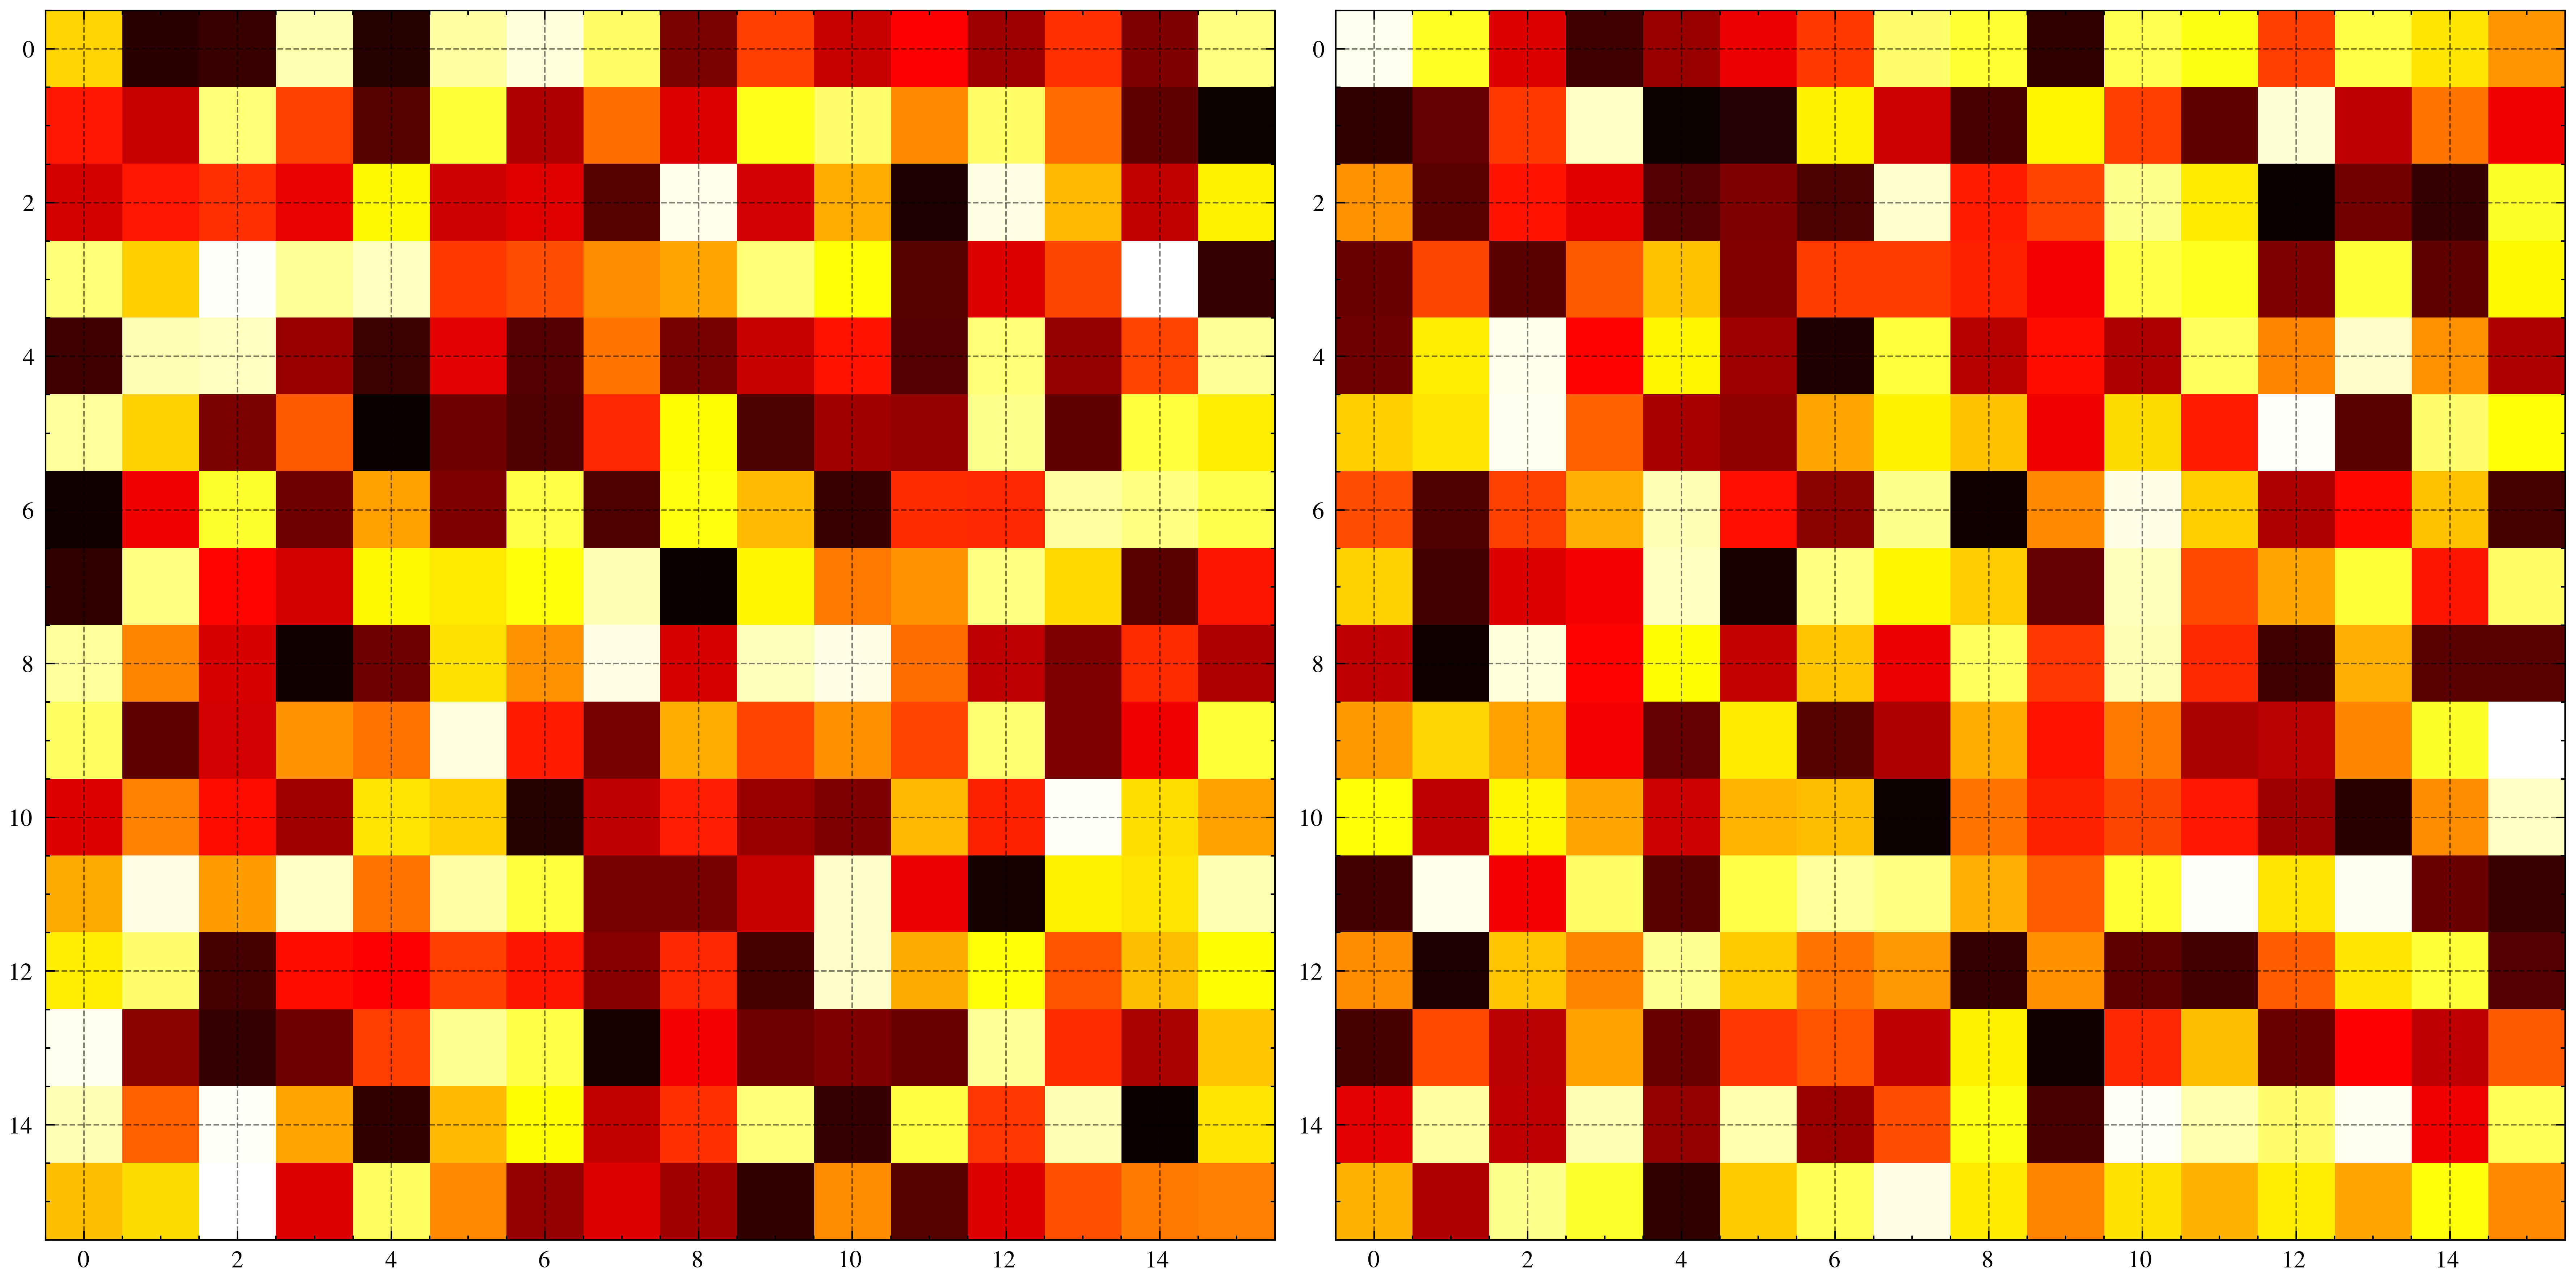

In [17]:
def sis_lineare_heatmap() -> np.ndarray[float, float]:
    M_lambda = np.zeros((len(N1), len(N2)))
    M_n_a = np.zeros((len(N1), len(N2)))

    for i, i_zip in enumerate(zip(N1, dx)):
        i_N1, i_dx = i_zip
        for j, j_N2 in enumerate(N2):
            M_lambda[i, j], M_n_a[i, j] = sis_lineare_medie(
                mN1=i_N1, mN2=j_N2, mdx=i_dx
            )

    print(M_lambda, M_n_a)

    fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
    ax1, ax2 = axes
    ax1.imshow(M_lambda, cmap="hot")
    ax2.imshow(M_n_a, cmap="hot")
    plt.tight_layout()
    plt.show()

    return


sis_lineare_heatmap()

confronto tra i lambda e n_a iniziali e quelli calcolati dal sistema

### Misura dei treni d'onda

In [15]:
dx = white_data[1, :] - white_data[0, :]

### Misura della separazione del doppietto del sodio

In [16]:
dx = Na_data[2, :] - Na_data[1, :]
m = Na_data[0, :]